## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [4]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [5]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [6]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [7]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [8]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [9]:
target = 'survived'

In [10]:
data.dtypes

pclass        int64
survived      int64
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
cabin        object
embarked     object
title        object
dtype: object

In [11]:
data["sex"].dtype

dtype('O')

In [12]:
vars_num = [var for var in data.columns if data[var].dtype != 'O']
print(vars_num)

['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare']


In [13]:
vars_cat = [var for var in data.columns if var not in vars_num]
print(vars_cat)

['sex', 'cabin', 'embarked', 'title']


In [14]:
print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 6
Number of categorical variables: 4


### Find missing values in variables

In [15]:
# first in numerical variables
for var in vars_num:
    print(var, data[var].isna().sum(), data[var].isna().sum()/len(data))


pclass 0 0.0
survived 0 0.0
age 263 0.20091673032849502
sibsp 0 0.0
parch 0 0.0
fare 1 0.0007639419404125286


In [16]:
# now in categorical variables
for var in vars_cat:
    print(var, data[var].isna().sum(), data[var].isna().sum()/len(data))
    

sex 0 0.0
cabin 1014 0.774637127578304
embarked 2 0.0015278838808250573
title 0 0.0


### Determine cardinality of categorical variables

In [17]:
data[vars_cat].nunique().sort_values(ascending=False)

cabin       181
title         5
embarked      3
sex           2
dtype: int64

<Axes: >

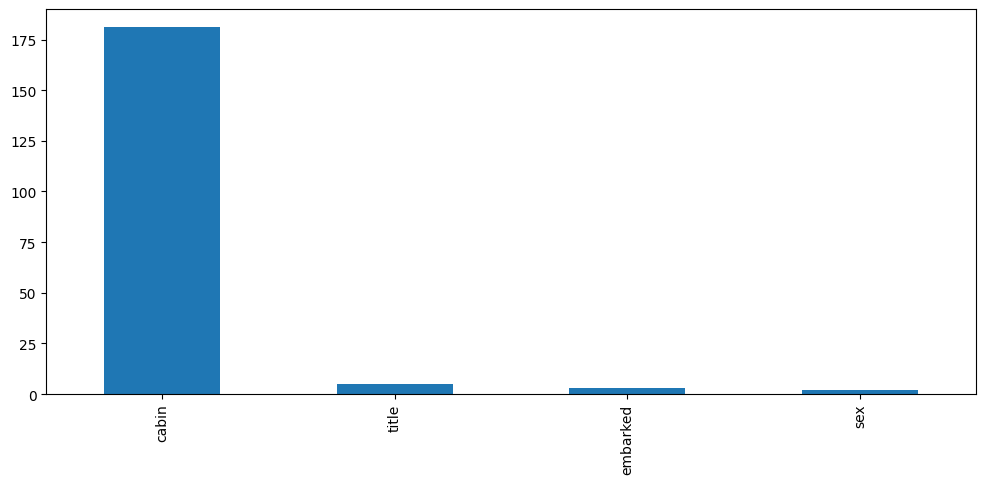

In [18]:
data[vars_cat].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

### Determine the distribution of numerical variables

In [19]:
discrete_vars = [var for var in vars_num if data[var].nunique() < 20]
print(discrete_vars)

['pclass', 'survived', 'sibsp', 'parch']


In [20]:
for var in discrete_vars:
    print(data[var].value_counts())

pclass
3    709
1    323
2    277
Name: count, dtype: int64
survived
0    809
1    500
Name: count, dtype: int64
sibsp
0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: count, dtype: int64
parch
0    1002
1     170
2     113
3       8
4       6
5       6
6       2
9       2
Name: count, dtype: int64


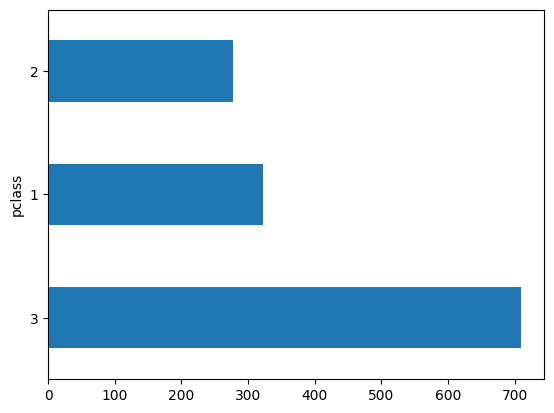

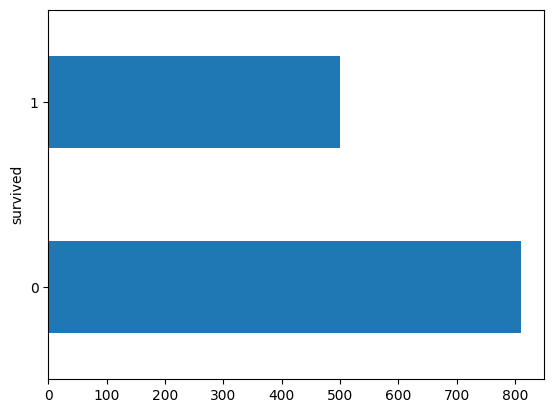

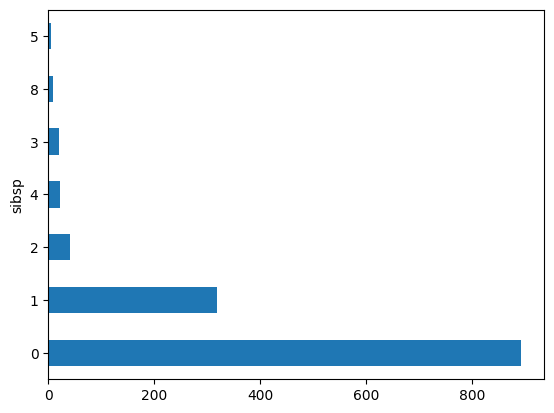

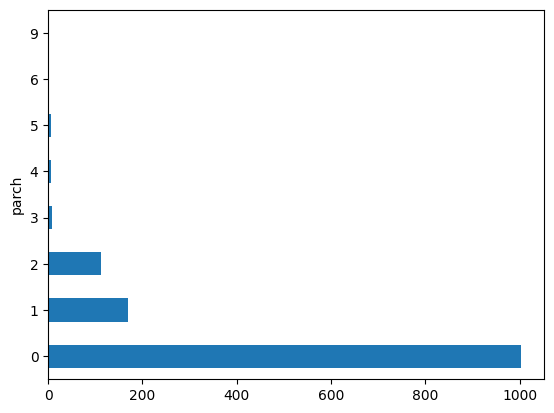

In [21]:
for var in discrete_vars:
    data[var].value_counts().plot.barh()
    plt.show()

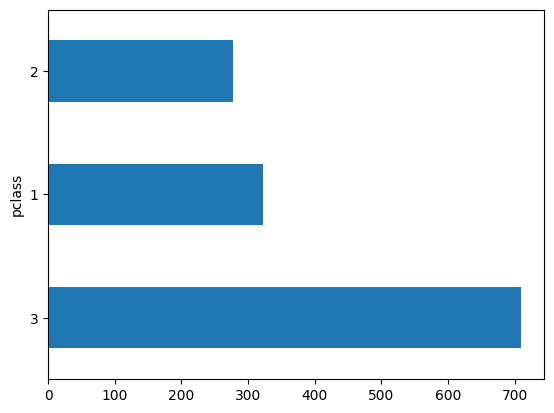

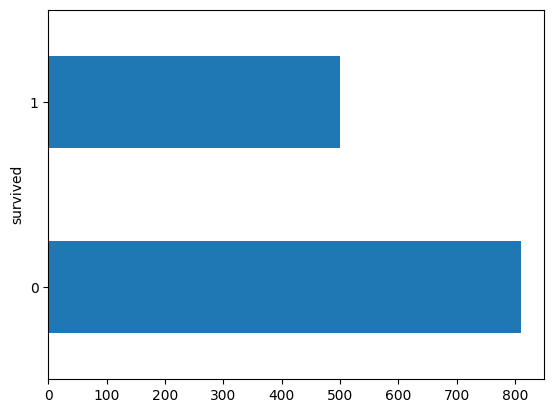

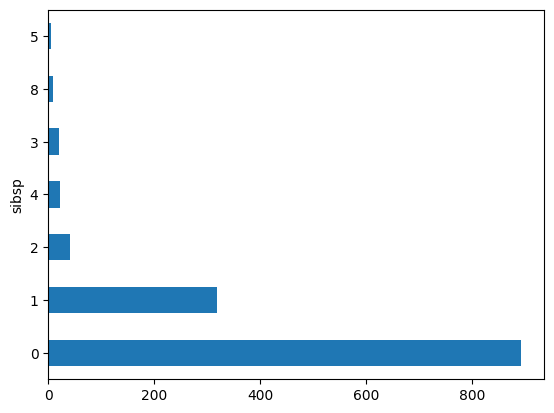

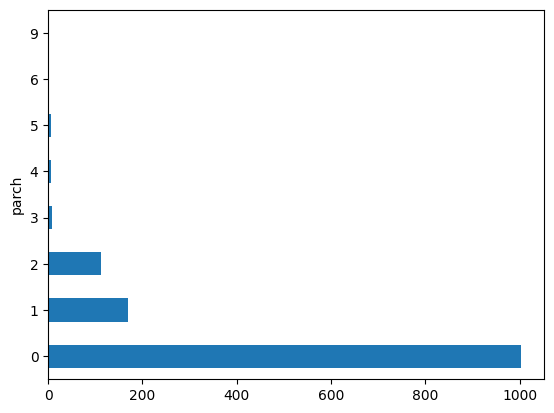

In [22]:
for var in discrete_vars:
    data[var].value_counts().plot(kind="barh")
    plt.show()

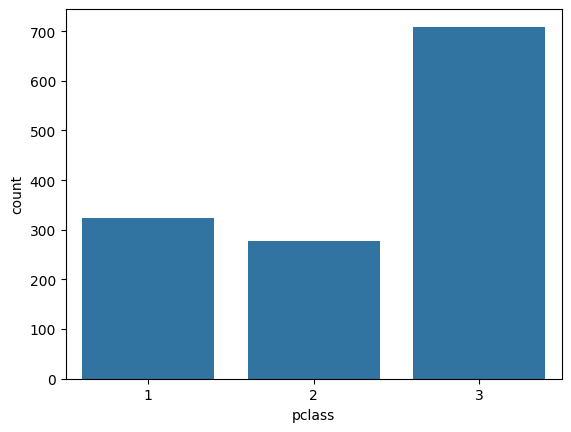

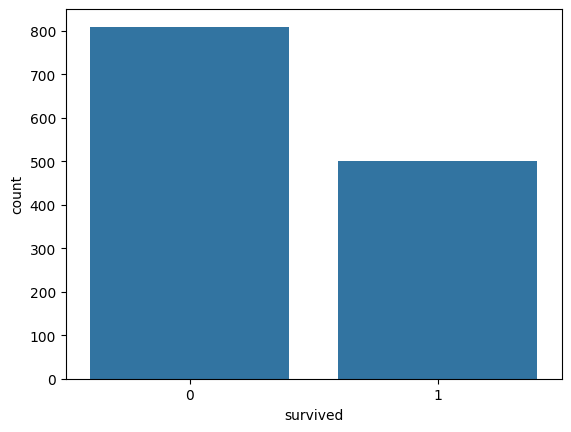

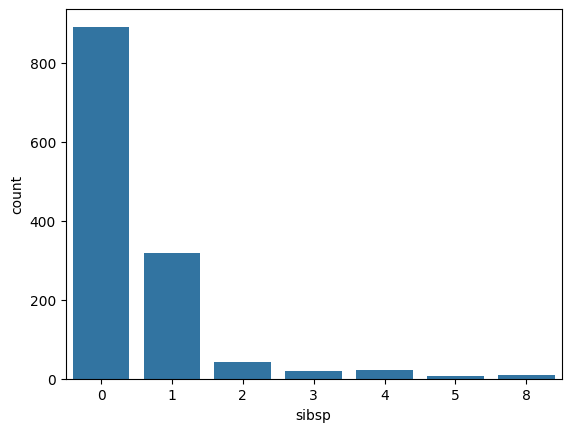

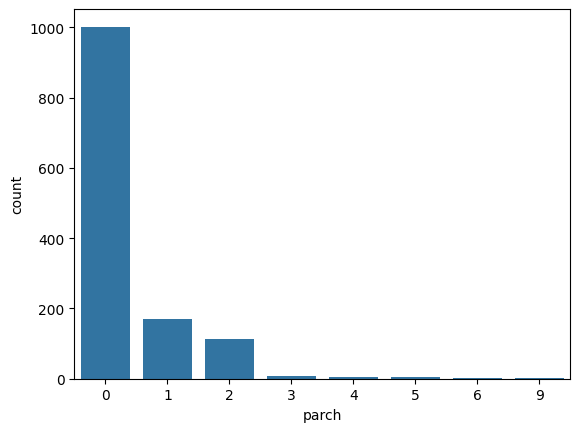

In [23]:
for var in discrete_vars:
    sns.countplot(data, x=var)
    plt.show()

In [24]:
cont_vars = [var for var in vars_num if var not in discrete_vars]
print(cont_vars)

['age', 'fare']


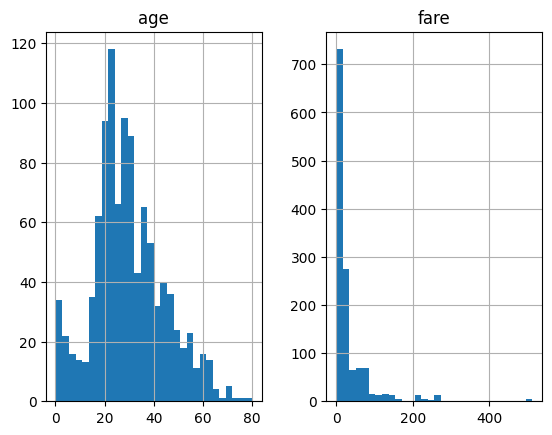

In [25]:
data[cont_vars].hist(bins=30)
plt.show()

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [27]:
X_train["cabin"]

1118    NaN
44      E40
1072    NaN
1130    NaN
574     NaN
       ... 
763     NaN
835     NaN
1216    NaN
559     NaN
684     NaN
Name: cabin, Length: 1047, dtype: object

In [28]:
X_test["cabin"]

1139    NaN
533     NaN
459     NaN
1150    NaN
393     NaN
       ... 
753     NaN
1052    NaN
426     NaN
554     NaN
1213    NaN
Name: cabin, Length: 262, dtype: object

In [29]:
X_train["cabin"] = np.where(X_train["cabin"].isna(), X_train["cabin"], X_train["cabin"].astype(str).str[0])
print(X_train["cabin"].unique())

[nan 'E' 'F' 'A' 'C' 'D' 'B' 'T' 'G']


In [30]:
X_test["cabin"] = np.where(X_test["cabin"].isna(), X_test["cabin"], X_test["cabin"].astype(str).str[0])
print(X_test["cabin"].unique())

[nan 'G' 'E' 'C' 'B' 'A' 'F' 'D']


### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [31]:
num_vars_with_na = [var for var in vars_num if data[var].isna().sum() > 0]
print(num_vars_with_na)

['age', 'fare']


In [32]:
for var in num_vars_with_na:
    # compute median value from the train set
    median_val = X_train[var].median()
    print(var, median_val)

    # add binary missing indicator
    X_train[var + "_na"] = np.where(X_train[var].isna(), 1, 0)
    X_test[var + "_na"] = np.where(X_test[var].isna(), 1, 0)

    # replace missing values by the median value
    X_train[var].fillna(median_val, inplace=True)
    X_test[var].fillna(median_val, inplace=True)    

age 28.0
fare 14.4542


/tmp/ipykernel_22674/2801289002.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[var].fillna(median_val, inplace=True)
/tmp/ipykernel_22674/2801289002.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [33]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na
1118,3,male,25.0,0,0,7.9250,NaN,S,Mr,0,0
44,1,female,41.0,0,0,134.5000,E,C,Miss,0,0
1072,3,male,28.0,0,0,7.7333,NaN,Q,Mr,1,0
1130,3,female,18.0,0,0,7.7750,NaN,S,Miss,0,0
574,2,male,29.0,1,0,21.0000,NaN,S,Mr,0,0


### Replace Missing data in categorical variables with the string **Missing**

In [34]:
X_train[vars_cat] = X_train[vars_cat].fillna("Missing")
X_test[vars_cat] = X_test[vars_cat].fillna("Missing")

In [35]:
for var in vars_cat:
    print(var, X_train[var].isna().sum(), X_train[var].isna().sum() / len(X_train))
    print(var, X_test[var].isna().sum(), X_test[var].isna().sum() / len(X_test))

sex 0 0.0
sex 0 0.0
cabin 0 0.0
cabin 0 0.0
embarked 0 0.0
embarked 0 0.0
title 0 0.0
title 0 0.0


In [36]:
X_train[vars_cat]

,sex,cabin,embarked,title
1118,male,Missing,S,Mr
44,female,E,C,Miss
1072,male,Missing,Q,Mr
1130,female,Missing,S,Miss
574,male,Missing,S,Mr
...,...,...,...,...
763,female,Missing,S,Miss
835,male,Missing,S,Mr
1216,female,Missing,Q,Miss
559,female,Missing,S,Miss


In [37]:
X_test[vars_cat]

,sex,cabin,embarked,title
1139,male,Missing,S,Mr
533,female,Missing,S,Miss
459,male,Missing,S,Mr
1150,male,Missing,S,Mr
393,male,Missing,S,Mr
...,...,...,...,...
753,male,Missing,S,Mr
1052,male,Missing,S,Mr
426,male,Missing,S,Mr
554,male,Missing,S,Mr


### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [38]:
vars_cat

['sex', 'cabin', 'embarked', 'title']

In [39]:
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the houses in the dataset

    df = df.copy()

    tmp = df.groupby(var)[var].count() / len(df)

    return tmp[tmp > rare_perc].index

In [40]:
for var in vars_cat:
    
    # find the frequent categories
    frequent_labels = find_frequent_labels(X_train, var, 0.05)
    
    print(var, frequent_labels)
    print()
    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(frequent_labels), X_train[var], "Rare")
    
    X_test[var] = np.where(X_test[var].isin(frequent_labels), X_test[var], "Rare")

sex Index(['female', 'male'], dtype='object', name='sex')

cabin Index(['C', 'Missing'], dtype='object', name='cabin')

embarked Index(['C', 'Q', 'S'], dtype='object', name='embarked')

title Index(['Miss', 'Mr', 'Mrs'], dtype='object', name='title')



### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [41]:
for var in vars_cat:
    labels_to_hot_encode = sorted(list(X_train[var].unique()))
    print(f"Var: {var}")
    print(f"Labels: {labels_to_hot_encode}")
    
    if "Missing" in labels_to_hot_encode:
        labels_to_hot_encode.remove("Missing")
    elif "Rare" in labels_to_hot_encode:
        labels_to_hot_encode.remove("Rare")
    else:
        labels_to_hot_encode.pop(-1)
    print(f"Labels to hot encode {labels_to_hot_encode}")
    print()
    
    for label in labels_to_hot_encode:
        X_train[var + "_" + label] = np.where(X_train[var]==label, 1, 0)
        X_test[var + "_" + label] = np.where(X_test[var]==label, 1, 0)

    X_train.drop(columns=var, inplace=True)
    X_test.drop(columns=var, inplace=True)


Var: sex
Labels: ['female', 'male']
Labels to hot encode ['female']

Var: cabin
Labels: ['C', 'Missing', 'Rare']
Labels to hot encode ['C', 'Rare']

Var: embarked
Labels: ['C', 'Q', 'Rare', 'S']
Labels to hot encode ['C', 'Q', 'S']

Var: title
Labels: ['Miss', 'Mr', 'Mrs', 'Rare']
Labels to hot encode ['Miss', 'Mr', 'Mrs']



In [42]:
X_train.head(10)

,pclass,age,sibsp,parch,fare,age_na,fare_na,sex_female,cabin_C,cabin_Rare,embarked_C,embarked_Q,embarked_S,title_Miss,title_Mr,title_Mrs
1118,3,25.0,0,0,7.9250,0,0,0,0,0,0,0,1,0,1,0
44,1,41.0,0,0,134.5000,0,0,1,0,1,1,0,0,1,0,0
1072,3,28.0,0,0,7.7333,1,0,0,0,0,0,1,0,0,1,0
1130,3,18.0,0,0,7.7750,0,0,1,0,0,0,0,1,1,0,0
574,2,29.0,1,0,21.0000,0,0,0,0,0,0,0,1,0,1,0
1217,3,19.0,0,0,7.6500,0,0,0,0,1,0,0,1,0,1,0
500,2,46.0,0,0,26.0000,0,0,0,0,0,0,0,1,0,1,0
958,3,28.0,0,4,25.4667,1,0,1,0,0,0,0,1,0,0,1
269,1,28.0,0,0,26.0000,1,0,0,0,1,0,0,1,0,1,0
322,1,36.0,0,0,135.6333,0,0,1,1,0,1,0,0,1,0,0


In [43]:
X_test.head(10)

,pclass,age,sibsp,parch,fare,age_na,fare_na,sex_female,cabin_C,cabin_Rare,embarked_C,embarked_Q,embarked_S,title_Miss,title_Mr,title_Mrs
1139,3,38.0,0,0,7.8958,0,0,0,0,0,0,0,1,0,1,0
533,2,21.0,0,1,21.0000,0,0,1,0,0,0,0,1,1,0,0
459,2,42.0,1,0,27.0000,0,0,0,0,0,0,0,1,0,1,0
1150,3,28.0,0,0,14.5000,1,0,0,0,0,0,0,1,0,1,0
393,2,25.0,0,0,31.5000,0,0,0,0,0,0,0,1,0,1,0
1189,3,4.0,1,1,16.7000,0,0,1,0,1,0,0,1,1,0,0
5,1,48.0,0,0,26.5500,0,0,0,0,1,0,0,1,0,1,0
231,1,52.0,0,0,30.5000,0,0,0,1,0,0,0,1,0,0,0
330,2,57.0,0,0,13.0000,0,0,0,0,0,0,0,1,0,1,0
887,3,28.0,0,0,8.1125,1,0,0,0,0,0,0,1,0,1,0


### Scale the variables

- Use the standard scaler from Scikit-learn

In [44]:
# create scaler
scaler = StandardScaler()

#  fit  the scaler to the train set
scaler.fit(X_train) 

# transform the train and test set
X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [45]:
model = LogisticRegression(C=0.0005, random_state=0)

model.fit(X_train, y_train)

LogisticRegression(C=0.0005, random_state=0)

In [46]:
model.classes_

array([0, 1])

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [48]:
class_ = model.predict(X_train)
print(class_)

[0 1 0 ... 0 0 0]


In [49]:
model.predict_proba(X_train)

array([[0.69473852, 0.30526148],
       [0.44036983, 0.55963017],
       [0.6967691 , 0.3032309 ],
       ...,
       [0.5718296 , 0.4281704 ],
       [0.54545067, 0.45454933],
       [0.54646264, 0.45353736]])

In [50]:
pred = model.predict_proba(X_train)[:,1]
print(pred)

[0.30526148 0.55963017 0.3032309  ... 0.4281704  0.45454933 0.45353736]


In [51]:
# make predictions for train set
class_ = model.predict(X_train)
pred = model.predict_proba(X_train)[:,1]

# determine accuracy and roc-auc
print(f"train roc-auc: {roc_auc_score(y_train, pred)}")
print(f"train accuracy: {accuracy_score(y_train, class_)}")
print()

train roc-auc: 0.8441421947449769
train accuracy: 0.7144221585482331



Confusion matrix: [[642   5]
 [294 106]]


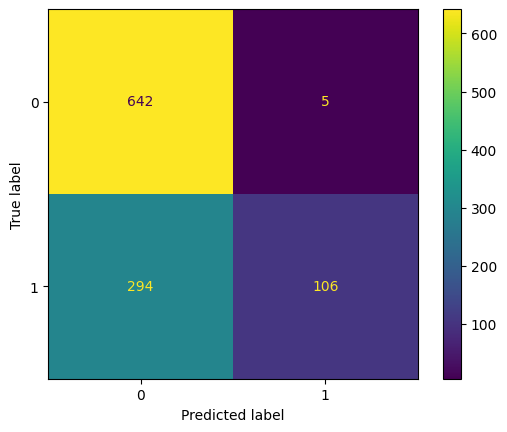

In [53]:
# confusion matrix for train set
cm_train = confusion_matrix(y_train, class_)
print(f"Confusion matrix: {cm_train}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=model.classes_)
disp.plot()
plt.show()

In [54]:
# make predictions for test set
class_ = model.predict(X_test)
pred = model.predict_proba(X_test)[:,1]

# determine accuracy and roc-auc
print(f"test roc-auc: {roc_auc_score(y_test, pred)}")
print(f"test accuracy: {accuracy_score(y_test, class_)}")
print()

test roc-auc: 0.838179012345679
test accuracy: 0.7061068702290076



Confusion matrix: [[162   0]
 [ 77  23]]


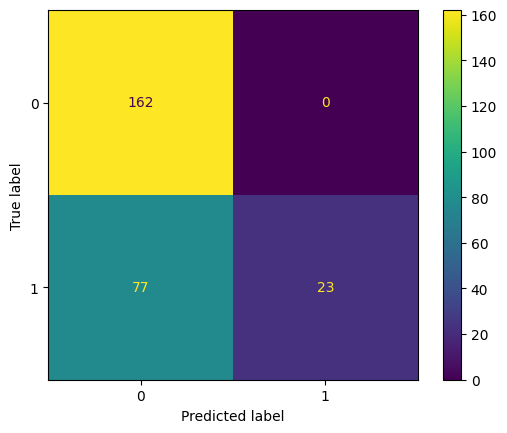

In [55]:
# confusion matrix for test set
cm_test = confusion_matrix(y_test, class_)
print(f"Confusion matrix: {cm_test}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=model.classes_)
disp.plot()
plt.show()